#Importação das bibliotecas e métodos

In [37]:
#importação das bibliotecas
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#Endereço do dataset da base de dados do SUS


In [38]:
url = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2022/INFLUD22-03-04-2023.csv"

#Leitura do dataset

Aqui ocorre a leitura e a exibição das informações com relação ao dataset

In [39]:
data = pd.read_csv(url, sep=";")
data.info()
print(f"Read in {len(data)} rows")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557476 entries, 0 to 557475
Columns: 173 entries, DT_NOTIFIC to DT_TRT_COV
dtypes: float64(95), int64(12), object(66)
memory usage: 735.8+ MB
Read in 557476 rows


#Pré Processamento do dataset

Remoção das colunas e linhas de forma manual para melhorar o dataset


Remoção das colunas que sejam redundantes e inuteis para a tarefa de classificação

In [40]:
data.drop(['DT_NASC', 'TP_IDADE','CS_ESCOL_N', 'CO_PAIS', 'DT_DIGITA', 'FNT_IN_COV', 'ID_PAIS','LOTE_2_COV','FAB_COV_1',
        'AVE_SUINO', 'POS_PCRFLU', 'POS_PCROUT', 'HISTO_VGM', 'PCR_SARS2', 'ID_REGIONA','ID_MUNICIP','FAB_COV_2','LAB_PR_COV',
        'ID_UNIDADE', 'ID_RG_RESI', 'ID_MN_RESI', 'ID_RG_INTE', 'ID_MN_INTE', 'COD_IDADE', 'LOTE_1_COV',
          ], axis=1, inplace=True)
data.shape

(557476, 148)

Remoção das linhas em que a coluna EVOLUCAO seja 3 (não informado) e 9 (causa da morte por outros fatores)

In [41]:
aux = data[(data['EVOLUCAO'] == 3) | (data['EVOLUCAO'] == 9)].index
data.drop(aux, inplace=True)
data.shape

(528938, 148)

Passagem do dataset para a variável x e exibição dos dados

In [42]:
x = data
x.head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,CO_REGIONA,CO_MUN_NOT,CO_UNI_NOT,CS_SEXO,NU_IDADE_N,CS_GESTANT,CS_RACA,SG_UF,CO_RG_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,M_AMAMENTA,DT_DOSEUNI,DT_1_DOSE,DT_2_DOSE,ANTIVIRAL,TP_ANTIVIR,OUT_ANTIV,DT_ANTIVIR,HOSPITAL,DT_INTERNA,SG_UF_INTE,CO_RG_INTE,CO_MU_INTE,UTI,DT_ENTUTI,DT_SAIDUTI,SUPORT_VEN,RAIOX_RES,RAIOX_OUT,DT_RAIOX,AMOSTRA,DT_COLETA,TP_AMOSTRA,OUT_AMOST,PCR_RESUL,DT_PCR,TP_FLU_PCR,PCR_FLUASU,FLUASU_OUT,PCR_FLUBLI,FLUBLI_OUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DS_PCR_OUT,CLASSI_FIN,CLASSI_OUT,CRITERIO,EVOLUCAO,DT_EVOLUCA,DT_ENCERRA,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,FAB_COVREF,LOTE_REF,DOSE_2REF,FAB_COVRF2,LOTE_REF2,TRAT_COV,TIPO_TRAT,OUT_TRAT,DT_TRT_COV
0,05/01/2022,1,02/01/2022,1,RJ,NaN,330455,7101856,M,23,6,4,RJ,NaN,330455.0,NaN,NaN,NaN,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,05/01/2022,RJ,NaN,330455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,05/01/2022,4.0,OROFARINGE,2.0,10/01/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,1.0,05/01/2022,07/01/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,25/01/2021,22/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04/01/2022,1,03/01/2022,1,MS,1966.0,500370,2371375,F,37,5,4,MS,1966.0,500370.0,1.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,1.0,04/01/2022,MS,1966.0,500370.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,04/01/2022,1.0,NaN,1.0,08/01/2022,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,06/01/2022,10/01/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,NaN,NaN,NaN,2.0,04/01/2022,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,07/06/2021,10/09/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07/01/2022,1,04/01/2022,1,GO,1791.0,521890,5584108,F,33,5,4,GO,1791.0,521890.0,1.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,07/01/2022,GO,1791.0,521890.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,07/01/2022,1.0,NaN,2.0,11/02/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,1.0,NaN,15/01/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,07/01/2022,2.0,2.0,2.0,2.0,1.0,21/01/2021,17/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07/01/2022,1,04/01/2022,1,GO,1792.0,520110,2442108,M,76,6,4,GO,1792.0,520110.0,1.0,NaN,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,24/12/2021,GO,1792.0,520110.0,1.0,07/01/2022,NaN,3.0,6.0,NaN,NaN,1.0,07/01/2022,1.0,NaN,2.0,07/01/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,2.0,23/01/2022,07/02/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07/0

Remoção das linhas que não sejam do estado do Paraná e após ocorre a remoção das colunas que representam o estado, visto que não serão mais necessárias para o restante da tarefa

In [43]:
aux = x[(x['SG_UF_NOT'] != 'PR')].index
x.drop(aux , inplace=True)
x.drop(['SG_UF_NOT','SG_UF','SG_UF_INTE'], axis=1, inplace=True)
x.info()
print(f"Read in {len(x)} rows")

<class 'pandas.core.frame.DataFrame'>
Index: 52169 entries, 13 to 557470
Columns: 145 entries, DT_NOTIFIC to DT_TRT_COV
dtypes: float64(90), int64(8), object(47)
memory usage: 58.1+ MB
Read in 52169 rows


Removendo todas as linhas em que o diagnostico não seja COVID-19

In [44]:
aux = x[(x['CLASSI_FIN'] != 5)].index
x.drop(aux , inplace=True)
x.drop(['CLASSI_FIN'], axis=1, inplace=True)
x.info()
print(f"Read in {len(x)} rows")

<class 'pandas.core.frame.DataFrame'>
Index: 18369 entries, 55 to 557467
Columns: 144 entries, DT_NOTIFIC to DT_TRT_COV
dtypes: float64(89), int64(8), object(47)
memory usage: 20.3+ MB
Read in 18369 rows


Sepação das colunas em que o 9 representa alguma informação importante do restante, visto que para o restante do dataset o 9 indica que o dado não foi preenchido

In [45]:
number_columns = x[['SEM_NOT','SEM_PRI','NU_IDADE_N','CS_GESTANT','OBES_IMC']]
x.drop(['SEM_NOT','SEM_PRI','NU_IDADE_N','CS_GESTANT','OBES_IMC'], axis=1, inplace=True)
x = x.replace(9, np.nan)
x = pd.concat([x, number_columns], axis=1)

Filtro para remoção das colunas onde tenham mais de 50% dos dados não preenchidos

In [46]:
#remoção das colunas com 50% de dados faltantes
x.dropna(axis=1, thresh=9111, subset=None, inplace=True)
x.shape

(18369, 55)

Filtro para remoção das linhas que tenham mais de 50% dos dados não preenchidos

In [47]:
#Remoção das linhas com 50% de dados faltantes
x.dropna(axis=0, thresh=38, subset=None, inplace=True)
x.shape

(17243, 55)

Ocorre a transformação das datas em dias fazendo a relação entre ambas, assim transformando duas colunas em uma

In [48]:
dates = ['DT_SIN_PRI', 'DT_INTERNA', 'DT_COLETA', 'DT_PCR', 'DT_EVOLUCA', 'DOSE_1_COV', 'DOSE_2_COV']
x['DT_NOTIFIC'] = pd.to_datetime(x['DT_NOTIFIC'],infer_datetime_format=True, errors='coerce')
x['DT_ENCERRA'] = pd.to_datetime(x['DT_ENCERRA'],infer_datetime_format=True, errors='coerce')
x['TEMP_T'] = abs(x['DT_ENCERRA'] - x['DT_NOTIFIC']).dt.days
x = x.drop(['DT_NOTIFIC', 'DT_ENCERRA'],axis=1)

In [49]:
x[dates].head()

,DT_SIN_PRI,DT_INTERNA,DT_COLETA,DT_PCR,DT_EVOLUCA,DOSE_1_COV,DOSE_2_COV
55,16/01/2022,20/01/2022,21/01/2022,28/01/2022,09/03/2022,25/05/2021,30/08/2021
82,28/01/2022,28/01/2022,28/01/2022,28/01/2022,31/01/2022,19/04/2021,19/07/2021
104,28/01/2022,02/02/2022,02/02/2022,05/02/2022,06/02/2022,30/03/2021,23/04/2021
248,26/05/2022,28/05/2022,28/05/2022,06/06/2022,01/06/2022,19/08/2021,21/09/2021
325,02/06/2022,04/06/2022,04/06/2022,NaN,09/06/2022,NaN,NaN


Transformação das datas em o total de dias a partir do dia 0

In [50]:
dates = ['DT_SIN_PRI', 'DT_INTERNA', 'DT_COLETA', 'DT_PCR', 'DT_EVOLUCA', 'DOSE_1_COV', 'DOSE_2_COV']
for column in dates:
  x[column] = pd.to_datetime(x[column], infer_datetime_format=True, errors='coerce').apply(lambda d: d.toordinal() if pd.notnull(d) else np.nan)
x["CS_SEXO"] = x["CS_SEXO"].replace({"F": 0, "M": 1})
x["EVOLUCAO"] = x["EVOLUCAO"].replace({1 : 0, 2 : 1})


In [51]:
x[dates].head()

,DT_SIN_PRI,DT_INTERNA,DT_COLETA,DT_PCR,DT_EVOLUCA,DOSE_1_COV,DOSE_2_COV
55,738171,738175.0,738176.0,738183.0,738401.0,737935.0,738032.0
82,738183,738183.0,738183.0,738183.0,NaN,737899.0,737990.0
104,738183,738188.0,738188.0,738191.0,738308.0,737879.0,737903.0
248,738301,738303.0,738303.0,738312.0,738161.0,738021.0,738054.0
325,738308,738310.0,738310.0,NaN,738404.0,NaN,NaN


In [52]:
#x.info()

Separação dos dados númericos do restante do dataset, para o preenchimento dos dados faltantes e normalização

In [53]:
dadosnumericos = x[['SEM_NOT', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'DT_SIN_PRI', 'DT_INTERNA', 'DT_COLETA',
                   'DT_PCR', 'DT_EVOLUCA', 'TEMP_T', 'DOSE_1_COV', 'DOSE_2_COV']]

x.drop(columns=['SEM_NOT', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'DT_SIN_PRI', 'DT_INTERNA', 'DT_COLETA',
                   'DT_PCR', 'DT_EVOLUCA', 'TEMP_T', 'DOSE_1_COV', 'DOSE_2_COV'], inplace=True)

#função de preenchimento dos dados faltantes
def preenchimento_NaN(x, estrategia):
  imputer = SimpleImputer(missing_values=np.nan, strategy=estrategia)
  nome = x.columns
  imputer = imputer.fit(x)
  x = imputer.transform(x)
  x = pd.DataFrame(x)
  x.columns = nome
  return x

#função de normalização
def Normalizacao(x, tecnica):
  nome = x.columns
  if(tecnica == 1):
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    x.columns = nome
  else:
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    x.columns = nome
  return x

dadosnumericos = preenchimento_NaN(dadosnumericos, 'median')
x = preenchimento_NaN(x, 'most_frequent')

num_MinMax = Normalizacao(dadosnumericos, 1)
num_Standard = Normalizacao(dadosnumericos, 2)

#concatenação dos dados sem normalização
x_SemNorm = pd.concat([x, dadosnumericos], axis=1)
x_SemNorm.loc[x_SemNorm['VACINA_COV'] == 2.0, ['DOSE_1_COV', 'DOSE_2_COV']] = 0

#concatenação dos dados normalizados com MinMax
x_MinMax = pd.concat([x, num_MinMax], axis=1)
x_MinMax.loc[x_MinMax['VACINA_COV'] == 2.0, ['DOSE_1_COV', 'DOSE_2_COV']] = 0

#concatenção do x com os dados normalizados com scaler
x_Standard = pd.concat([x, num_Standard], axis=1)
x_Standard.loc[x_Standard['VACINA_COV'] == 2.0, ['DOSE_1_COV', 'DOSE_2_COV']] = 0

In [54]:
y = x['EVOLUCAO']
datasets = [x_SemNorm, x_MinMax, x_Standard]

for dataset in datasets:
  dataset.drop(columns = 'EVOLUCAO', inplace=True)
#pd.set_option('display.max_rows', None)

# Classificação

Aqui acontece a classificação, utilizando o método de RandomForest com validação cruzada

In [55]:
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
clf = RandomForestClassifier(max_depth=5, random_state=43)
nomedataset = ["Sem Normalização","com MinMax", "Com Scaler"]

for dataset, nome in zip(datasets, nomedataset):
  print(f" \n {nome} \n")
  scores = cross_validate(clf, dataset, y, cv=10, scoring=metrics)
  print(f"Accuracy:  {scores['test_accuracy']}")
  print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
  print(f"Precision_Macro: {scores['test_precision_macro']}")
  print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_precision_macro']), np.std(scores['test_precision_macro'])))
  print(f" Recall_Macro: {scores['test_recall_macro']}")
  print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))
  print(f"F1_Macro: {scores['test_f1_macro']}")
  print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_f1_macro']), np.std(scores['test_f1_macro'])))

 
 Sem Normalização 

Accuracy:  [0.82550725 0.84       0.84115942 0.83642691 0.83932715 0.82656613
 0.84164733 0.8312065  0.8474478  0.83758701]
Média: 0.84 | Desvio: 0.0066
Precision_Macro: [0.79888889 0.8193518  0.83905636 0.81266808 0.84477466 0.79363668
 0.81052493 0.81034887 0.85495408 0.82685789]
Média: 0.82 | Desvio: 0.019
 Recall_Macro: [0.6378978  0.67258683 0.66486806 0.6656426  0.65716371 0.64521295
 0.6849739  0.65007143 0.67553642 0.66074699]
Média: 0.66 | Desvio: 0.014
F1_Macro: [0.66501375 0.70582056 0.69921726 0.69764769 0.6907375  0.67321472
 0.7174495  0.68003847 0.71256011 0.69352123]
Média: 0.69 | Desvio: 0.016
 
 com MinMax 

Accuracy:  [0.82550725 0.84       0.84115942 0.83642691 0.83932715 0.82656613
 0.84164733 0.8312065  0.8474478  0.83758701]
Média: 0.84 | Desvio: 0.0066
Precision_Macro: [0.79888889 0.8193518  0.83905636 0.81266808 0.84477466 0.79363668
 0.81052493 0.81034887 0.85495408 0.82685789]
Média: 0.82 | Desvio: 0.019
 Recall_Macro: [0.6378978  0.6725

#Curva ROC

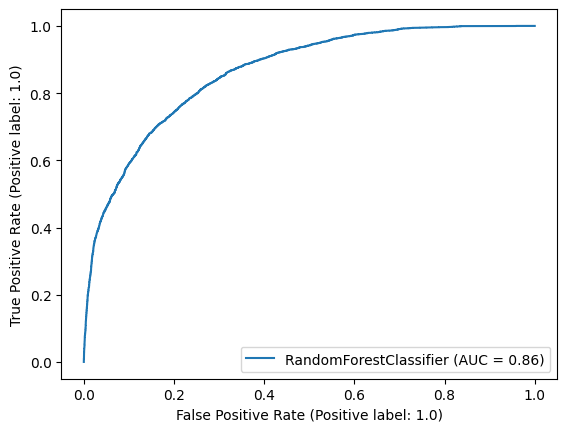

In [56]:
clf.fit(x_SemNorm, y)
testeroc = RocCurveDisplay.from_estimator(clf, x_SemNorm, y)
plt.show()

#Desbalanceamento

Aqui trataremos o desbalanceamento de nossa Base de dados

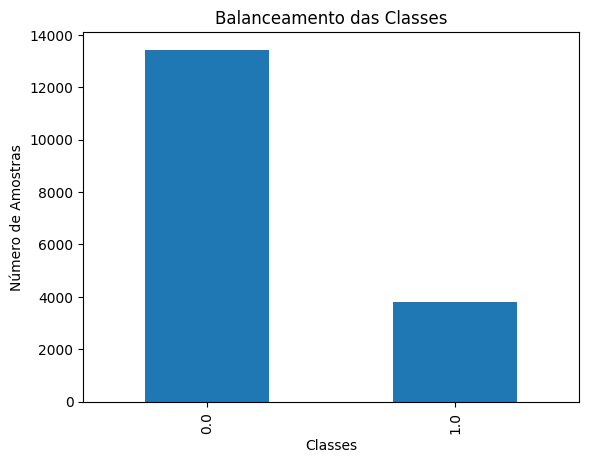

In [57]:
count_classes = y.value_counts()
count_classes.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.title('Balanceamento das Classes')
plt.show()

Quantidade de cada classe

In [58]:
for classe, quantidade in count_classes.items():
    print(f"Classe {classe}: {quantidade} amostras")

Classe 0.0: 13433 amostras
Classe 1.0: 3810 amostras


In [59]:
sample = RandomUnderSampler()
x_under, y_under = sample.fit_resample(x_SemNorm, y)
count_classes = y_under.value_counts()
for classe, quantidade in count_classes.items():
    print(f"Classe {classe}: {quantidade} amostras")

Classe 0.0: 3810 amostras
Classe 1.0: 3810 amostras


In [60]:
scores = cross_validate(clf, x_under, y_under, cv=10, scoring=metrics)
print(f"Accuracy:  {scores['test_accuracy']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
print(f"Precision_Macro: {scores['test_precision_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_precision_macro']), np.std(scores['test_precision_macro'])))
print(f" Recall_Macro: {scores['test_recall_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))
print(f"F1_Macro: {scores['test_f1_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_f1_macro']), np.std(scores['test_f1_macro'])))

Accuracy:  [0.74278215 0.75328084 0.77165354 0.75853018 0.78608924 0.75721785
 0.77034121 0.76902887 0.77427822 0.78608924]
Média: 0.77 | Desvio: 0.013
Precision_Macro: [0.74374935 0.75428986 0.77177337 0.75898692 0.7864227  0.75940696
 0.77049214 0.76929601 0.77428577 0.78618584]
Média: 0.77 | Desvio: 0.013
 Recall_Macro: [0.74278215 0.75328084 0.77165354 0.75853018 0.78608924 0.75721785
 0.77034121 0.76902887 0.77427822 0.78608924]
Média: 0.77 | Desvio: 0.013
F1_Macro: [0.74252674 0.75303585 0.77162837 0.75842368 0.78602696 0.75670456
 0.77030917 0.76897158 0.77427666 0.78607119]
Média: 0.77 | Desvio: 0.013


Aplicação o OverSampling

In [61]:
sample = RandomOverSampler()
x_over, y_over = sample.fit_resample(x_SemNorm, y)
count_classes = y_over.value_counts()
for classe, quantidade in count_classes.items():
    print(f"Classe {classe}: {quantidade} amostras")

Classe 1.0: 13433 amostras
Classe 0.0: 13433 amostras


In [62]:
scores = cross_validate(clf, x_over, y_over, cv=10, scoring=metrics)
print(f"Accuracy:  {scores['test_accuracy']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
print(f"Precision_Macro: {scores['test_precision_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_precision_macro']), np.std(scores['test_precision_macro'])))
print(f" Recall_Macro: {scores['test_recall_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))
print(f"F1_Macro: {scores['test_f1_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_f1_macro']), np.std(scores['test_f1_macro'])))

Accuracy:  [0.75846669 0.75325642 0.78675102 0.78228508 0.76702642 0.76814291
 0.75837677 0.7728965  0.77810871 0.76805659]
Média: 0.77 | Desvio: 0.01
Precision_Macro: [0.75927426 0.75371295 0.78774426 0.78238327 0.76807518 0.76898191
 0.75910093 0.77296975 0.778782   0.76857493]
Média: 0.77 | Desvio: 0.01
 Recall_Macro: [0.75847705 0.75326428 0.78676194 0.78228158 0.76701476 0.76813249
 0.75837677 0.7728965  0.77810871 0.76805659]
Média: 0.77 | Desvio: 0.01
F1_Macro: [0.75828336 0.7531492  0.78657117 0.78226469 0.76679305 0.76795728
 0.75820782 0.77288126 0.77797466 0.76794462]
Média: 0.77 | Desvio: 0.01


Aplicando os métodos de balanceamento undersampler e oversampler

In [63]:
# Aplicando undersampling e oversampling
balance = SMOTEENN(sampling_strategy=str('all'), random_state=None, n_jobs=-1)
x_final, y_final = balance.fit_resample(x_MinMax, y)

Exibindo o resultado do balanceamento

In [64]:
count_classes = y_final.value_counts()
for classe, quantidade in count_classes.items():
    print(f"Classe {classe}: {quantidade} amostras")

Classe 1.0: 10022 amostras
Classe 0.0: 7504 amostras


Reavaliando o desempenho com a base balanceada

In [65]:
scores = cross_validate(clf, x_final, y_final, cv=10, scoring=metrics)
print(f"Accuracy:  {scores['test_accuracy']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
print(f"Precision_Macro: {scores['test_precision_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_precision_macro']), np.std(scores['test_precision_macro'])))
print(f" Recall_Macro: {scores['test_recall_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))
print(f"F1_Macro: {scores['test_f1_macro']}")
print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(scores['test_f1_macro']), np.std(scores['test_f1_macro'])))

Accuracy:  [0.80718768 0.81118083 0.89332573 0.92127781 0.91500285 0.92470051
 0.90924658 0.89554795 0.91324201 0.90981735]
Média: 0.89 | Desvio: 0.042
Precision_Macro: [0.80500873 0.81022294 0.89803107 0.93412923 0.92601264 0.93745449
 0.92135219 0.91144458 0.92669553 0.92297768]
Média: 0.9 | Desvio: 0.047
 Recall_Macro: [0.81099054 0.81665165 0.88467207 0.91012383 0.90419807 0.91368162
 0.89768862 0.88168862 0.9013493  0.8978523 ]
Média: 0.88 | Desvio: 0.035
F1_Macro: [0.8056286  0.81000339 0.88945564 0.91771028 0.91126038 0.92128809
 0.90508158 0.89007287 0.90914599 0.90555965]
Média: 0.89 | Desvio: 0.041


In [66]:
data = pd.concat([x_final, y_final], axis=1)
data.to_csv('dataset.csv')